In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import glob
import pandas as pd
import numpy as np
from sglm.helpers import filehelpers as fh, dfhelpers as dfh
from pathlib import Path
from collections import defaultdict
from tqdm.notebook import tqdm, trange
import scipy.stats
import matplotlib.pyplot as plt
from sglm.helpers import filehelpers as fh, dfhelpers as dfh


In [4]:
# base_alignment_lst = [
#     'SIr', 'SInr',
#     'SIAA', 'SIAa',
#     'SIAB', 'SIAb',
#     'SIaA', 'SIaa',
#     'SIaB', 'SIab',
# ]

base_alignment_lst = [
    'CI', 'CO',
    'SI', 'SIr',
    'SIAA', 'SIAa',
    'SIAB', 'SIAb',
    'SIaA', 'SIaa',
    'SIaB', 'SIab',
    'SO', 'sl',
    'spnnrOff', 'gDA', 'rDA', 'gACH'
]

In [5]:
def update_max_min(mx_val, mn_val, new_val_mx, new_val_mn):
    mx_chg = new_val_mx > mx_val
    mn_chg = new_val_mn < mn_val
    
    ret_mx = new_val_mx if mx_chg else mx_val
    ret_mn = new_val_mn if mn_chg else mn_val
    return ret_mx, ret_mn, mx_chg, mn_chg

Created directory: C:\Users\Josh\Documents\GitHub\sabatinilab-glm\sglm\outputs-old\final_out_tet_run_20230403--20_20sft_0-ft_krn_fig_folder
Continuing... file not found: Figure_7_g1--20_20sft-kernels-gDAt=0_base_simple*.csv
Continuing... file not found: Figure_7_g1--20_20sft-kernels-gDAt=1_base_words*.csv
Created directory: C:\Users\Josh\Documents\GitHub\sabatinilab-glm\sglm\outputs-old\final_out_tet_run_20230403--20_20sft_1-ft_krn_fig_folder
Continuing... file not found: Figure_7_g1--20_20sft-kernels-gDAc=0_base_simple*.csv
Continuing... file not found: Figure_7_g1--20_20sft-kernels-gDAc=1_base_words*.csv
Continuing... file not found: Figure_7_g1--20_20sft-kernels-gDAt=0_base_simple*.csv
Continuing... file not found: Figure_7_g1--20_20sft-kernels-gDAt=1_base_words*.csv


C:\Users\Josh\AppData\Local\Temp\ipykernel_13224\3958090685.py:108: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


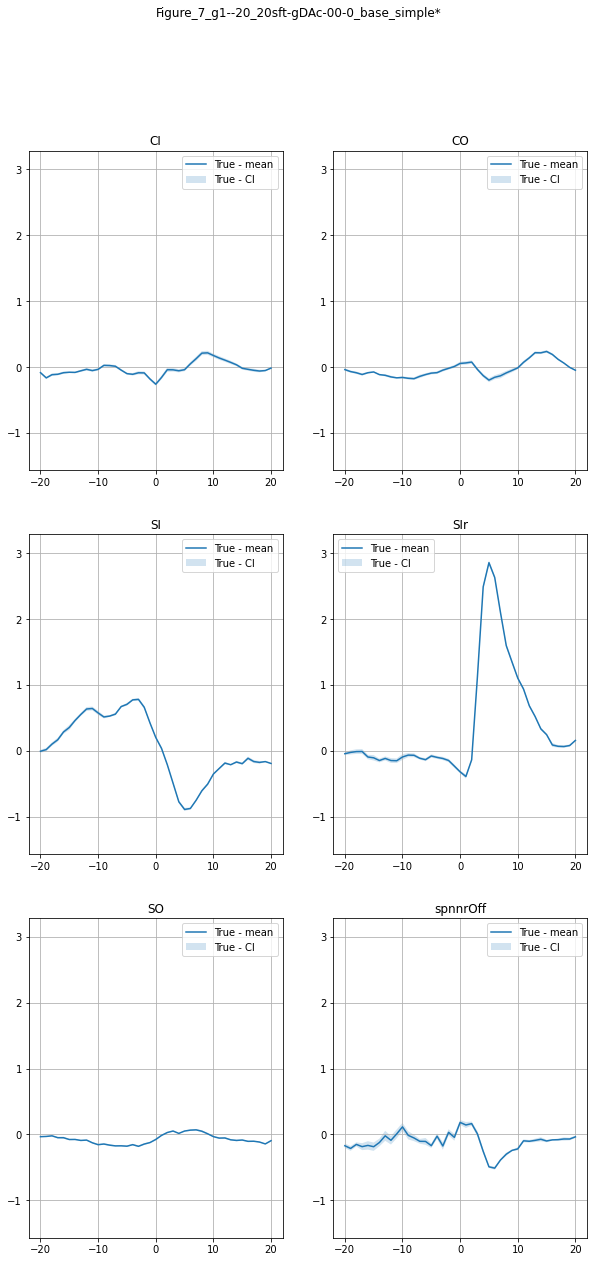

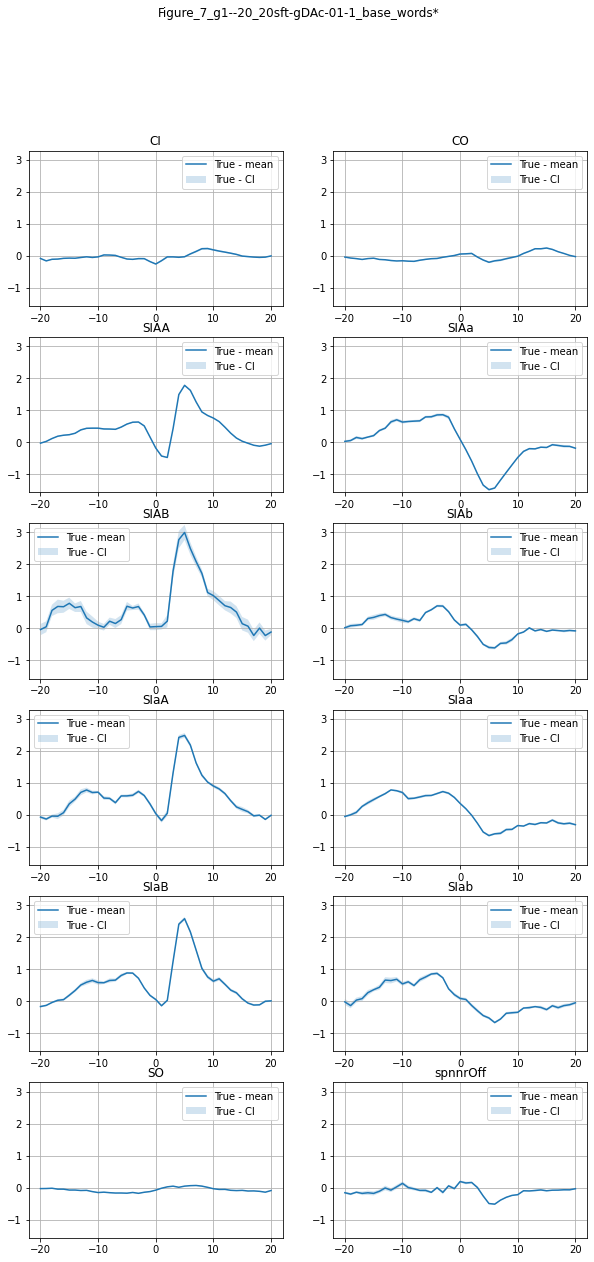

In [6]:
# fig_str_lst = ['Figure_1_2', 'Figure_3', 'Figure_4_g1', 'Figure_4_g2', 'Figure_5_g1', 'Figure_5_g2', 'Figure_5_g5']
# y_col_lst = ['gACH', 'gDA', 'rDA']

# fig_str_lst = ['Figure_6_g1']
# fig_str_lst = ['Figure_6_g1-20sft']
# fig_str_lst = ['Figure_6_g1-50sft']
# fig_str_lst = ['Figure_6_g1--20_20sft']
fig_str_lst = ['Figure_7_g1--20_20sft']
# y_col_lst = ['gGLUr']
y_col_lst = ['gDAc', 'gDAt']
modl_lst_base = ['0_base_simple*', '1_base_words*']

modl_btw_chls = ['gDA_to_gACH', 'rDA_to_gACH', 'gACH_to_gDA', 'gACH_to_rDA']
modl_btw_chls_smpl = [f'base_simple_{_}' for _ in modl_btw_chls]
modl_btw_chls_wrds = [f'base_words_{_}' for _ in modl_btw_chls]

# src_folder_name = 'final_out_glu_run_20221202-no-CO_0-ft'
# src_folder_name = 'final_out_glu_run_20221202-30sft_0-ft'
# src_folder_name = 'final_out_glu_run_20221202-30sft-reduc_0-ft'
# src_folder_name = 'final_out_glu_run_20221202-30sft-paperfig_0-ft'
# src_folder_name = 'final_out_glu_run_20221212-20sft-paperfig_0-ft'
# src_folder_name = 'final_out_glu_run_20221213-50sft-paperfig_0-ft'
src_folder_names = ['final_out_tet_run_20230403--20_20sft_0-ft',
                    'final_out_tet_run_20230403--20_20sft_1-ft']


# dr_in = Path(r'/Users/josh/Downloads/final_outputs')
# dr_out = Path(r'/Users/josh/Desktop/output_fig_folder')

# dr_in = Path(r'C:\Users\Josh\Documents\GitHub\sabatinilab-glm\sglm\outputs\final_outputs_rev')
# dr_out = Path(r'C:\Users\Josh\Documents\GitHub\sabatinilab-glm\sglm\outputs\final_outputs_rev_krn_fig_folder')

for src_folder_name in src_folder_names:
    dr_in = Path(r'C:\Users\Josh\Documents\GitHub\sabatinilab-glm\sglm\outputs-old') / f'{src_folder_name}'
    dr_out = Path(r'C:\Users\Josh\Documents\GitHub\sabatinilab-glm\sglm\outputs-old') / f'{src_folder_name}_krn_fig_folder'

    fh.create_folder_if_not_exists(str(dr_out.resolve()))

    for fig_str in fig_str_lst:
        for y_col in y_col_lst:

            if fig_str == 'Figure_3':
                modl_lst = modl_btw_chls + modl_lst_base + modl_btw_chls_smpl + modl_btw_chls_wrds
            else:
                modl_lst = modl_lst_base

            fig_lst = []

            max_y = -np.inf
            min_y = np.inf

            for im, modl in enumerate(modl_lst):
                file_name = f'{fig_str}-kernels-{y_col}={modl}.csv'
                try:
                    file_loc = glob.glob(str((dr_in / file_name).resolve()))
                    if len(file_loc) == 0:
                        print(f'Continuing... file not found: {str(file_name)}')
                        continue
                    else:
                        file_loc = file_loc[0]
                    rdf = pd.read_csv(file_loc, index_col=0)
                except Exception as e:
                    print(e)
                    continue
    #             display(rdf)
    #             print(list(rdf.columns))

                has_col_lst = (list(set([_.split('_')[0] for _ in rdf.columns])))
                base_alignment_lst_use = [_ for _ in base_alignment_lst if _ in has_col_lst]
    #             print(base_alignment_lst)

                fig, axes = plt.subplots(int(np.ceil(len(base_alignment_lst_use)/2)), 2, figsize=(10,20))
                fig_name = f'{fig_str}-{y_col}-{str(im).zfill(2)}-{modl}'

                fig_lst.append((fig, axes, fig_name))

                fig.suptitle(f'{fig_name}')
                fig.set_facecolor('w')

                for iba, base_alignment in enumerate(base_alignment_lst_use):
                    ax = axes[iba//2, iba%2]

                    if f'{base_alignment}_mean' not in rdf.columns:
                        rdf[f'{base_alignment}_mean'] = np.nan
                        rdf[f'{base_alignment}_std'] = np.nan
                        rdf[f'{base_alignment}_size'] = np.nan

                    rdf[f'{base_alignment}_lb'] = rdf[f'{base_alignment}_mean'] - 1.96*rdf[f'{base_alignment}_std']/np.sqrt(rdf[f'{base_alignment}_size'])
                    rdf[f'{base_alignment}_ub'] = rdf[f'{base_alignment}_mean'] + 1.96*rdf[f'{base_alignment}_std']/np.sqrt(rdf[f'{base_alignment}_size'])

                    tmp_mx_y = rdf[f'{base_alignment}_ub'].max()
                    tmp_mn_y = rdf[f'{base_alignment}_lb'].min()
                    max_y, min_y, _, _ = update_max_min(max_y, min_y, tmp_mx_y, tmp_mn_y)

                    ax.plot(rdf.index, rdf[f'{base_alignment}_mean'], label='True - mean')
                    ax.fill_between(rdf.index, rdf[f'{base_alignment}_lb'], rdf[f'{base_alignment}_ub'], alpha=0.2, label='True - CI')

                    ax.set_title(base_alignment)
                    ax.grid(True)
                    ax.legend()
    #             break
    #         break
    #     break
            for fig, axes, fig_name in fig_lst:
                for ax in axes.reshape(-1):
                    ax.set_ylim(min_y-0.05, max_y+0.05)

                fig.show()
    #             fig.savefig(str((dr_out / (fig_name + '.png')).resolve()))
    #             break
    #         break
    #     break
    #             display(rdf)

In [7]:
str((dr_in / file_name).resolve())

'C:\\Users\\Josh\\Documents\\GitHub\\sabatinilab-glm\\sglm\\outputs-old\\final_out_tet_run_20230403--20_20sft_1-ft\\Figure_7_g1--20_20sft-kernels-gDAt=1_base_words*.csv'

In [8]:
# run_id_dct[y_col]

In [9]:
# # fig_str_lst = ['Figure_1_2']
# # y_col_lst = ['gACH', 'gDA', 'rDA']
# fig_str_lst = ['Figure_6_g1']
# y_col_lst = ['gGLUr']
# modl_lst_base = ['base_simple', 'base_words']


# # dr_in = Path(r'/Users/josh/Downloads/final_outputs')
# # dr_out = Path(r'/Users/josh/Desktop/output_fig_folder')

# dr_in = Path(r'C:\Users\Josh\Documents\GitHub\sabatinilab-glm\sglm\outputs\final_outputs')
# dr_out = None


# for fig_str in fig_str_lst:
#     for y_col in y_col_lst:
        
#         if fig_str == 'Figure_3':
#             modl_lst = modl_btw_chls + modl_lst_base + modl_btw_chls_smpl + modl_btw_chls_wrds
#         else:
#             modl_lst = modl_lst_base
        
#         fig_lst = []

#         max_y = -np.inf
#         min_y = np.inf

#         for im, modl in enumerate(modl_lst):
#             file_name = f'{fig_str}-kernels-{y_col}={modl}.csv'
#             file_loc = str((dr_in / file_name).resolve())
#             try:
#                 rdf = pd.read_csv(file_loc, index_col=0)
#             except Exception as e:
#                 print(e)
#                 continue
# #             display(rdf)
# #             print(list(rdf.columns))

#             has_col_lst = (list(set([_.split('_')[0] for _ in rdf.columns])))
#             base_alignment_lst_use = [_ for _ in base_alignment_lst if _ in has_col_lst]
# #             print(base_alignment_lst)

#             fig, axes = plt.subplots(int(np.ceil(len(base_alignment_lst_use)/2)), 2, figsize=(10,20))
#             fig_name = f'{fig_str}-{y_col}-{str(im).zfill(2)}-{modl}'
            
#             fig_lst.append((fig, axes, fig_name))
            
#             fig.suptitle(f'{fig_name}')
#             fig.set_facecolor('w')
            
#             for iba, base_alignment in enumerate(base_alignment_lst_use):
#                 ax = axes[iba//2, iba%2]
                
#                 if f'{base_alignment}_mean' not in rdf.columns:
#                     rdf[f'{base_alignment}_mean'] = np.nan
#                     rdf[f'{base_alignment}_std'] = np.nan
#                     rdf[f'{base_alignment}_size'] = np.nan
                
#                 rdf[f'{base_alignment}_lb'] = rdf[f'{base_alignment}_mean'] - 1.96*rdf[f'{base_alignment}_std']/np.sqrt(rdf[f'{base_alignment}_size'])
#                 rdf[f'{base_alignment}_ub'] = rdf[f'{base_alignment}_mean'] + 1.96*rdf[f'{base_alignment}_std']/np.sqrt(rdf[f'{base_alignment}_size'])
                
#                 tmp_mx_y = rdf[f'{base_alignment}_ub'].max()
#                 tmp_mn_y = rdf[f'{base_alignment}_lb'].min()
#                 max_y, min_y, _, _ = update_max_min(max_y, min_y, tmp_mx_y, tmp_mn_y)

#                 ax.plot(rdf.index, rdf[f'{base_alignment}_mean'], label='True - mean')
#                 ax.fill_between(rdf.index, rdf[f'{base_alignment}_lb'], rdf[f'{base_alignment}_ub'], alpha=0.2, label='True - CI')

#                 ax.set_title(base_alignment)
#                 ax.grid(True)
#                 ax.legend()